[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Niegil-Francis/astromer_notebooks/blob/main/Tutorial_classification_astromer.ipynb)

# Tutorial - Classification using Astromer

This tutorial will go through the steps required to perform classification using [Astromer](https://www.stellardnn.org/astromer/pages/about_astromer.html).

##### *Install the library*

In [1]:
%%capture
!pip install test_model_hv

##### *Mount the drive containing the custom dataset*

In [3]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


##### *Import the necessary modules*

In [4]:
from core.astromer import ASTROMER 
from core.data import pretraining_data
from core.utils import get_folder_name
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os
import warnings
import numpy as np
import pandas as pd
import argparse
import logging
import time
import os
from time import gmtime, strftime
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model, Input
warnings.filterwarnings("ignore")

 ##### *Load tf records and labels of the custom dataset*

In [5]:
train_data = pretraining_data("/content/drive/Shareddrives/AstroMer/public/records/ogle_500/train",
                                batch_size = 256,
                                shuffle=True,
                                max_obs=200,
                                msk_frac=0.5, 
                                rnd_frac=0.2, 
                                same_frac=0.2,
                                mode = 'clf')

val_data = pretraining_data("/content/drive/Shareddrives/AstroMer/public/records/ogle_500/val",
                                batch_size = 256,
                                shuffle=True,
                                max_obs=200,
                                msk_frac=0.5, 
                                rnd_frac=0.2, 
                                same_frac=0.2,
                                mode = 'clf')

test_data = pretraining_data("/content/drive/Shareddrives/AstroMer/public/records/ogle_500/test",
                                batch_size = 256,
                                shuffle=True,
                                max_obs=200,
                                msk_frac=0.5, 
                                rnd_frac=0.2, 
                                same_frac=0.2,
                                mode = 'clf')

label_dict = pd.read_csv("/content/drive/Shareddrives/AstroMer/public/records/ogle_500/objects.csv")['label'].to_dict()

[INFO] Shuffling
[INFO] Shuffling
[INFO] Shuffling


##### *Add the dense and softmax layers required for classification on top of the encoder to define an MLP+ATT model structure*

In [6]:
def get_mlp_backprop(num_classes, maxlen=200):
    ''' FC + ATT'''
    inputs = {
    'input': Input(shape=(maxlen, 1), name='input'),
    'times': Input(shape=(maxlen, 1), name='times'),
    'mask_in': Input(shape=(maxlen, 1), name='mask'),
    }

    model = ASTROMER(pretrained_weights="macho",  overwrite = True).get_model()

    
    model.trainable=True
    encoder = model.get_layer('encoder')

    m = tf.cast(1.-inputs['mask_in'][...,0], tf.bool)
    x = encoder(inputs)
    x = tf.ragged.boolean_mask(x, m)
    x = tf.reduce_mean(x, 1)

    x = Dense(1024, activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=inputs, outputs=x, name="MLP_ATT")

In [7]:
# Get the number of classes to pass into the function defined above
classes = len(label_dict)

##### *Load the model*

In [8]:
model_MLP = get_mlp_backprop(classes)
model_MLP.summary()

Loading Base Model...
Weights loaded successfully!
Model: "MLP_ATT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 200, 1)]     0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 200)         0           ['mask[0][0]']                   
 ingOpLambda)                                                                                     
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 200)          0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                                
                                         

##### *Train the model*

In [9]:
estop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=50,
    mode='auto',
    restore_best_weights=True)

In [10]:
optimizer = Adam(learning_rate=5e-4)

model_MLP.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(),
              metrics='accuracy')


In [11]:
hist = model_MLP.fit(train_data, 
                 epochs=500,
                 validation_data=val_data ,
                 callbacks=[estop],
                 verbose=0)

Epoch 1/500
12/12 [==============================] - 20s 701ms/step - loss: 2.0958 - accuracy: 0.3103 - val_loss: 2.8142 - val_accuracy: 0.1000
Epoch 2/500
12/12 [==============================] - 3s 277ms/step - loss: 1.6847 - accuracy: 0.4067 - val_loss: 2.8381 - val_accuracy: 0.1067
Epoch 3/500
12/12 [==============================] - 3s 277ms/step - loss: 1.5308 - accuracy: 0.4520 - val_loss: 2.6910 - val_accuracy: 0.1307
Epoch 4/500
12/12 [==============================] - 3s 273ms/step - loss: 1.4382 - accuracy: 0.4793 - val_loss: 2.4944 - val_accuracy: 0.1213
Epoch 5/500
12/12 [==============================] - 3s 278ms/step - loss: 1.3836 - accuracy: 0.5037 - val_loss: 2.5807 - val_accuracy: 0.1300
Epoch 6/500
12/12 [==============================] - 3s 273ms/step - loss: 1.3218 - accuracy: 0.5197 - val_loss: 2.4846 - val_accuracy: 0.1353
Epoch 7/500
12/12 [==============================] - 3s 273ms/step - loss: 1.2804 - accuracy: 0.5290 - val_loss: 2.2787 - val_accuracy: 0.154

##### *Plot the loss and accuracy*

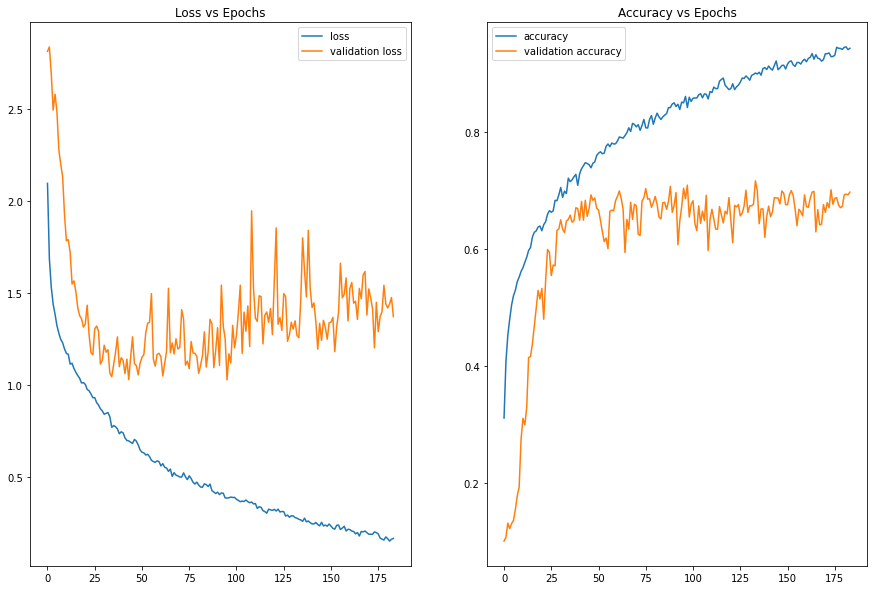

In [12]:
fig = plt.figure(figsize=(15,10))
epochs = hist.epoch
ax = fig.add_subplot(1,2,1)
ax.plot(epochs,hist.history['loss'],label = 'loss')
ax.plot(epochs,hist.history['val_loss'],label = 'validation loss')
ax.set_title("Loss vs Epochs")
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(epochs,hist.history['accuracy'],label = 'accuracy')
ax.plot(epochs,hist.history['val_accuracy'],label = 'validation accuracy')
ax.set_title("Accuracy vs Epochs")
ax.legend();



In [13]:
result = model_MLP.evaluate(test_data)

2/2 [==============================] - 3s 155ms/step - loss: 1.6221 - accuracy: 0.6680
